Comparison: Year 2015, Old: 202007F New:202007G

In [1]:
import cmocean.cm as cm
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import xarray as xr

from salishsea_tools import visualisations as vis
from salishsea_tools import viz_tools

%matplotlib inline

In [2]:
mesh = nc.Dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
bathy = nc.Dataset('/home/sallen/MEOPAR/grid/bathymetry_201702.nc')
tmask = mesh['tmask']
deptht = mesh['gdept_1d'][0]

In [3]:
year = '2015'
olddir = '202007/202007F/'
newdir = '202007/202007G/'

In [4]:
def surface_plots(tracers, file, month, cmap, cdiff, vmax, vmin, dvmax, twoD=False, olddir=olddir, zoom=[0, 0, 0, 0], dl=0, dosum=False):
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))

    dm = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{olddir}/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')

    if dosum:
        dm['summed'] = 0.*dm[tracers[0]]
        for tr in tracers:
            dm['summed'] = dm['summed'] + dm[tr]
        tracer = 'summed'
    else:
        tracer = tracers
    
    if twoD:
        mean_field = np.ma.array(dm[tracer][0], mask=1-tmask[0, 0])
    else:
        mean_field = np.ma.array(dm[tracer][0, dl], mask=1-tmask[0, dl])
    colours = axs[0].pcolormesh(mean_field, cmap=cmap, vmax=vmax, vmin=vmin)
    axs[0].set_title(olddir)
    fig.colorbar(colours, ax=axs[0])
    
    ds = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{newdir}/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')
    
    if dosum:
        ds['summed'] = 0.*ds[tracers[0]]
        for tr in tracers:
            ds['summed'] = ds['summed'] + ds[tr]
    
    if twoD:
        field = np.ma.array(ds[tracer][0], mask=1-tmask[0,0])
    else:
        field = np.ma.array(ds[tracer][0, dl], mask=1-tmask[0, dl])
    colours = axs[1].pcolormesh(field, cmap=cmap, vmax=vmax, vmin=vmin)
    axs[1].set_title(newdir)
    fig.colorbar(colours, ax=axs[1])
    
    colours = axs[2].pcolormesh(field-mean_field, cmap=cdiff, vmax=dvmax, vmin=-dvmax)
    axs[2].set_title("New - Old")
    fig.colorbar(colours, ax=axs[2])
    ds.close()
    dm.close()

    for ax in axs:
        viz_tools.set_aspect(ax)
        if sum(zoom) > 0:
            ax.set_ylim(zoom[0], zoom[1])
            ax.set_xlim(zoom[2], zoom[3])

    return fig

In [5]:
def profiles(tracers, file, olddir=olddir, dosum=False):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    dm = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{olddir}/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')
    
    if dosum:
        dm['summed'] = 0.*dm[tracers[0]]
        for tr in tracers:
            dm['summed'] = dm['summed'] + dm[tr]
        tracer = 'summed'
    else:
        tracer = tracers
    
    
    mean_field = np.ma.array(dm[tracer][0], mask=1-tmask[0])
    axs[0].plot(mean_field.mean(axis=1).mean(axis=1), deptht, linewidth=2, label='Old')
    axs[1].plot(np.zeros_like(deptht), deptht, linewidth=2, label='Old')
    
    ds = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{newdir}/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')
    
    if dosum:
        ds['summed'] = 0.*ds[tracers[0]]
        for tr in tracers:
            ds['summed'] = ds['summed'] + ds[tr]

    field = np.ma.array(ds[tracer][0], mask=1-tmask[0])
    axs[0].plot(field.mean(axis=1).mean(axis=1), deptht, label='New')
    
    axs[1].plot((field-mean_field).mean(axis=1).mean(axis=1), deptht, label='New')
    print (mean_field.mean(axis=1).mean(axis=1).max(), field.mean(axis=1).mean(axis=1).max())
    ds.close()
    dm.close()

    
    axs[0].invert_yaxis()
    axs[0].legend(loc='best')
    
    axs[1].invert_yaxis()
    axs[1].legend(loc='best')
    
    return fig

In [6]:
def thalweg_plots(tracers, file, cmap, cdiff, vmax, vmin, dvmax, olddir=olddir, maxdepth=0, dosum=False):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    dm = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{olddir}/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')
    
    if dosum:
        dm['summed'] = 0.*dm[tracers[0]]
        for tr in tracers:
            dm['summed'] = dm['summed'] + dm[tr]
        tracer = 'summed'
    else:
        tracer = tracers
        
    mean_field = np.array(dm[tracer][0])
    colours = vis.contour_thalweg(axs[0], mean_field, bathy, mesh,np.arange(vmin, 1.1*vmax+0.1*vmin, (vmax-vmin)/10.), cmap=cmap)
    axs[0].set_title(olddir)

    ds = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{newdir}/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')
    
    if dosum:
        ds['summed'] = 0.*ds[tracers[0]]
        for tr in tracers:
            ds['summed'] = ds['summed'] + ds[tr]

    field = np.array(ds[tracer][0])
    colours = vis.contour_thalweg(axs[1], field, bathy, mesh,np.arange(vmin, 1.1*vmax+0.1*vmin, (vmax-vmin)/10.), cmap=cmap)

    axs[1].set_title(newdir)
    colours = vis.contour_thalweg(axs[2], field-mean_field, bathy, mesh, np.arange(-dvmax, 1.2*dvmax, dvmax/5), 
                                      cmap=cdiff)
 
    axs[2].set_title('New - Old')
    if maxdepth > 0:
        for ax in axs:
            ax.set_ylim(maxdepth, 0)
    ds.close()
    dm.close()

    fig.tight_layout()
    return fig

## January: Temperature

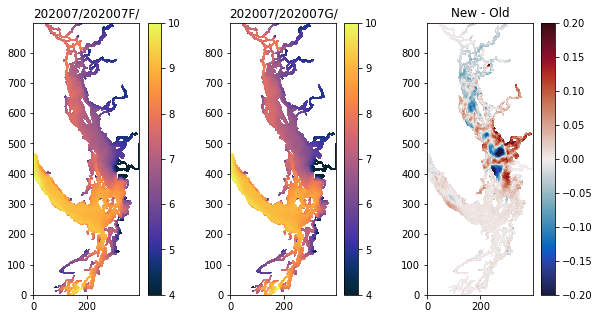

In [7]:
tracer = 'votemper'
file = 'grid'
month = '01'
cmap = cm.thermal
cdiff = cm.balance
vmax = 10
vmin = 4
dvmax = 0.2
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

9.569403334237107 9.56755797993946


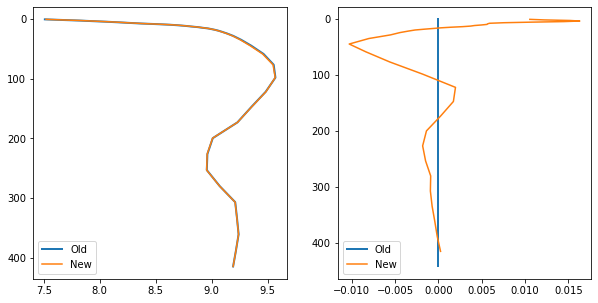

In [8]:
fig = profiles(tracer, file)

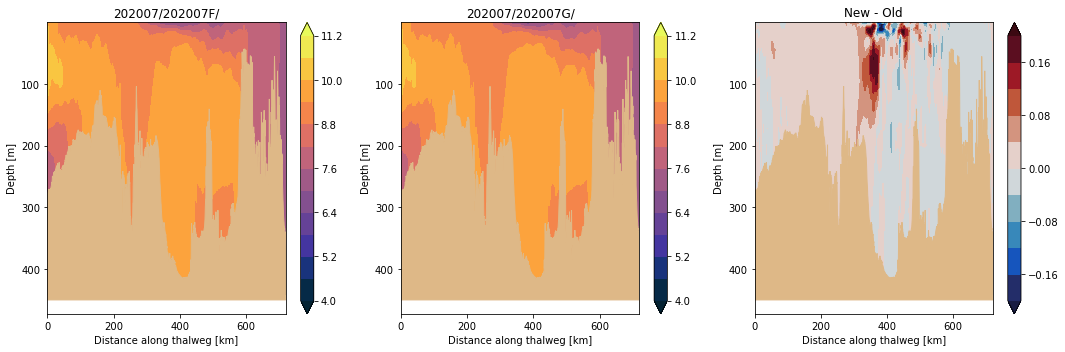

In [9]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

## January: Salinity

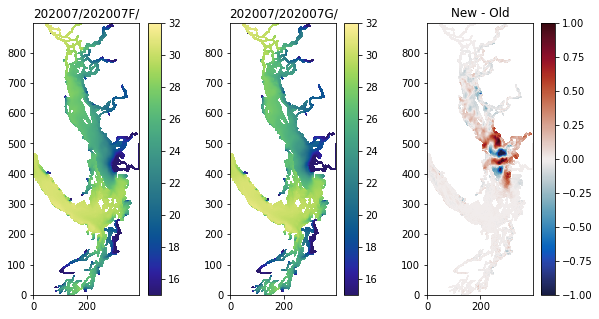

In [10]:
tracer = 'vosaline'
file = 'grid'
month = '01'
cmap = cm.haline
cdiff = cm.balance
vmax = 32
vmin = 15
dvmax = 1
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

31.678839660254575 31.678124285285346


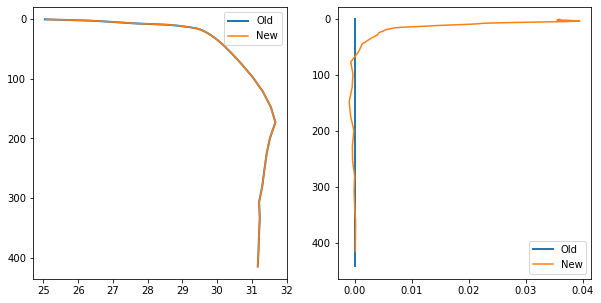

In [11]:
fig = profiles(tracer, file)

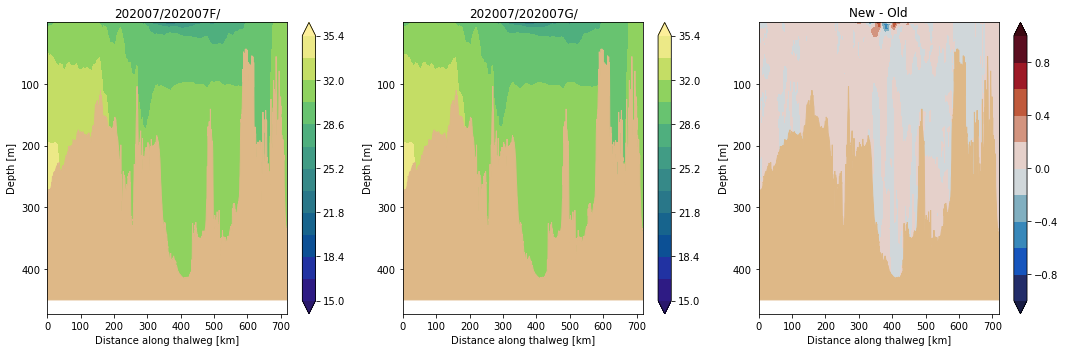

In [12]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

## January: Nitrate

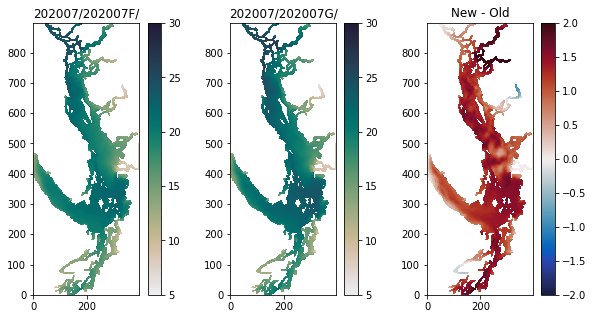

In [14]:
tracer = 'nitrate'
file = 'ptrc'
month = '01'
cmap = cm.rain
cdiff = cm.balance
vmax = 30
vmin = 5
dvmax = 2
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

28.952777691777026 30.12414310742324


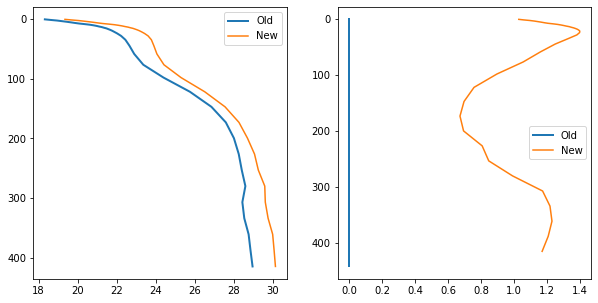

In [15]:
fig = profiles(tracer, file)

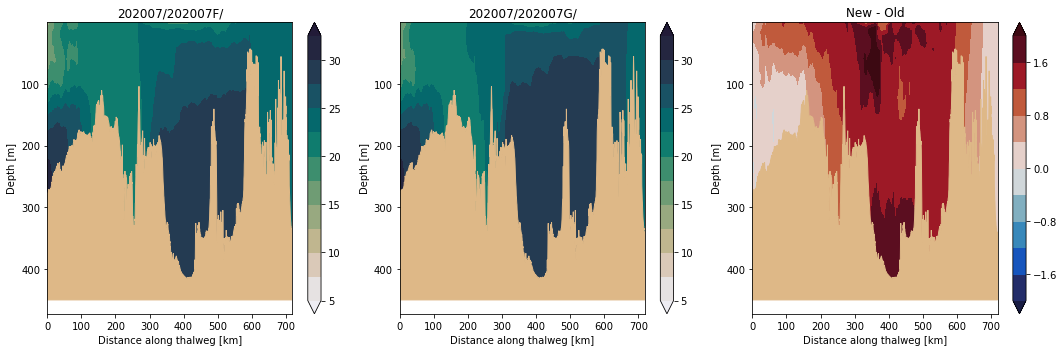

In [16]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

## January: Silicon

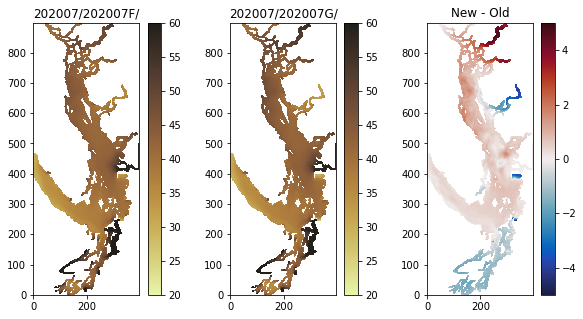

In [20]:
tracer = 'silicon'
file = 'ptrc'
month = '01'
cmap = cm.turbid
cdiff = cm.balance
vmax = 60
vmin = 20
dvmax = 5
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

68.30571184716526 70.58993021913666


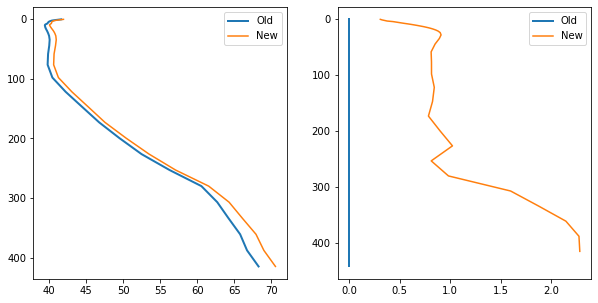

In [21]:
fig = profiles(tracer, file)

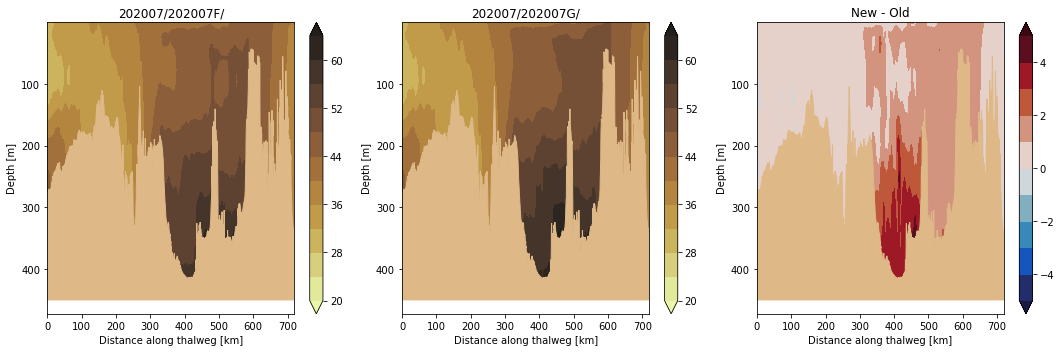

In [22]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

## January: Diatoms

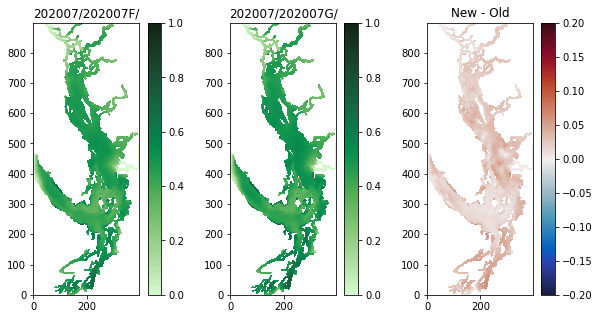

In [32]:
tracer = 'diatoms'
file = 'ptrc'
month = '01'
cmap = cm.algae
cdiff = cm.balance
vmax = 1
vmin = 0
dvmax = 0.2
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

0.4212131302053507 0.4422881916903832


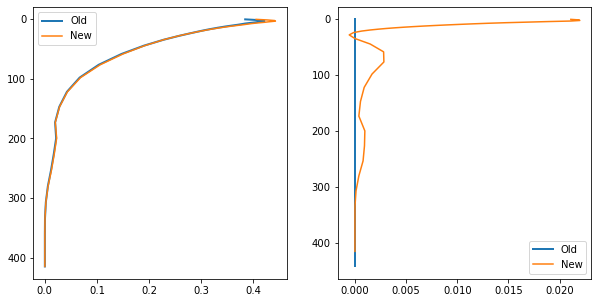

In [33]:
fig = profiles(tracer, file)

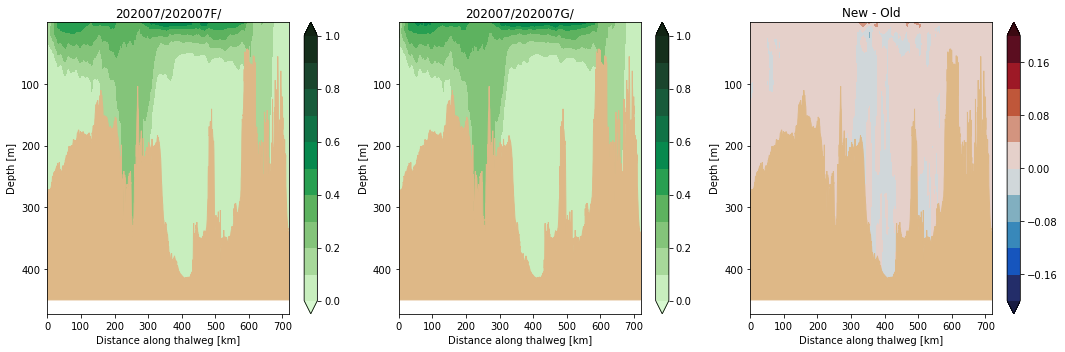

In [34]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

## January: Flagellates

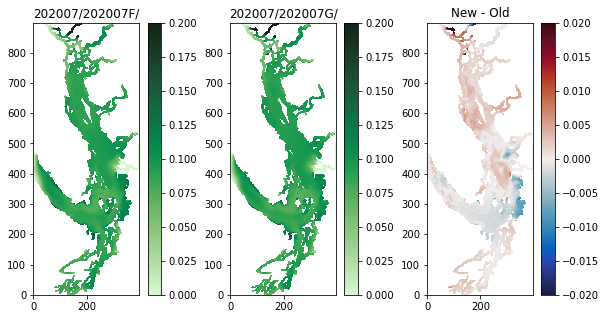

In [27]:
tracer = 'flagellates'
file = 'ptrc'
month = '01'
cmap = cm.algae
cdiff = cm.balance
vmax = 0.2
vmin = 0
dvmax = 0.02
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

0.08294959094983868 0.08331000475794348


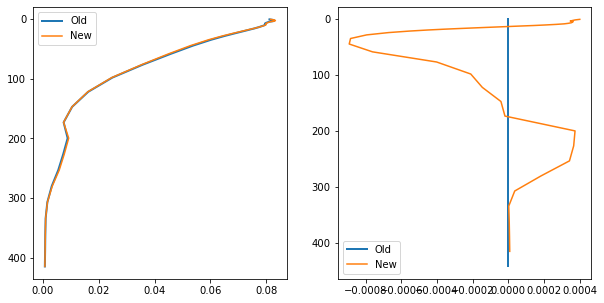

In [28]:
fig = profiles(tracer, file)

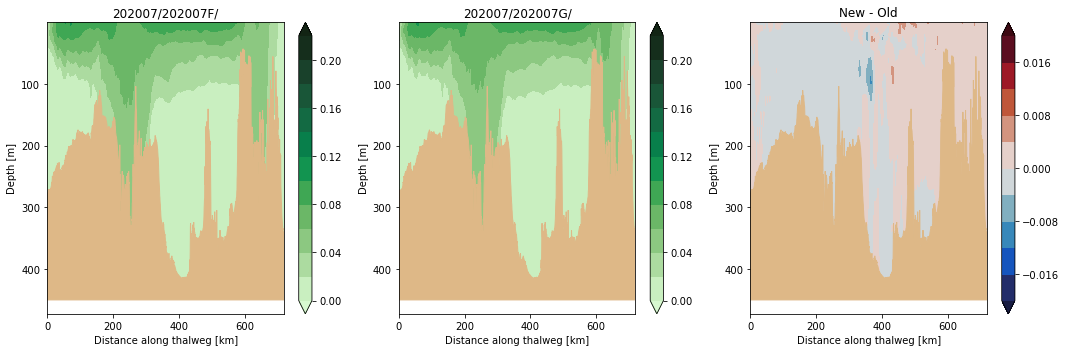

In [29]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

# NOTHING BEYOND JANUARY IS RUN FOR THIS CASE

## February: Nitrate

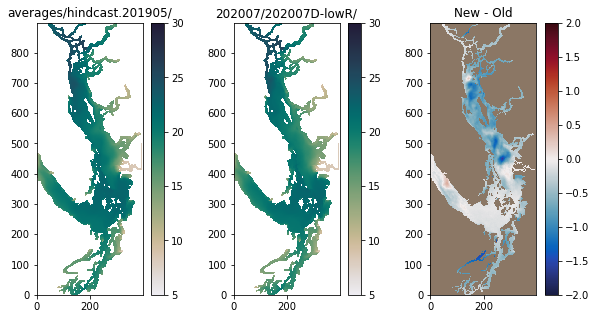

In [120]:
tracer = 'nitrate'
file = 'ptrc'
month = '02'
cmap = cm.rain
cdiff = cm.balance
vmax = 30
vmin = 5
dvmax = 2
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

29.10500382421713 29.104217487256694


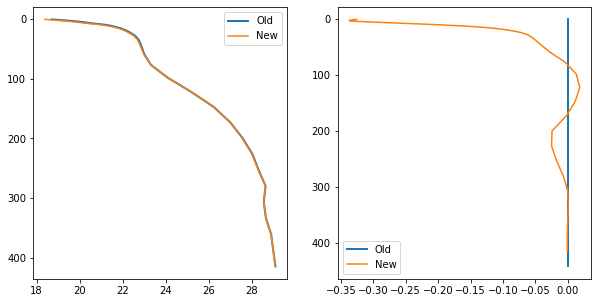

In [121]:
fig = profiles(tracer, file)

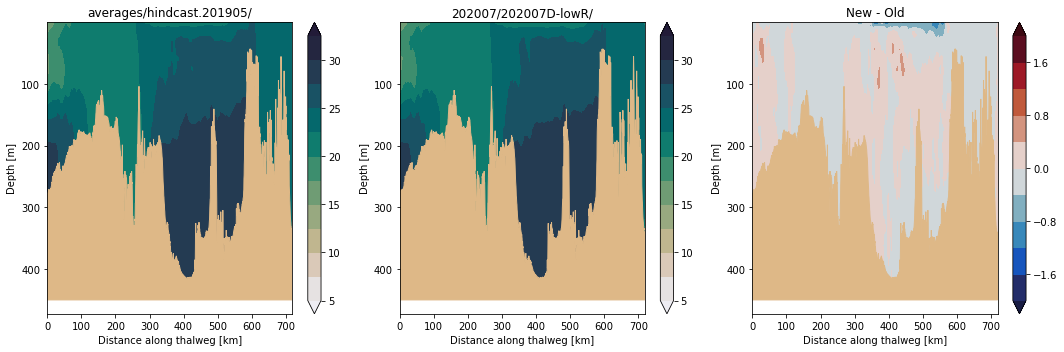

In [122]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

## February: Flagellates

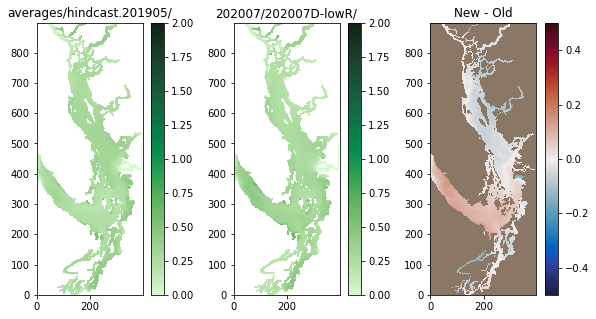

In [123]:
tracer = 'flagellates'
file = 'ptrc'
month = '02'
cmap = cm.algae
cdiff = cm.balance
vmax = 2
vmin = 0
dvmax = 0.5
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

0.2623085411812389 0.2817212635403949


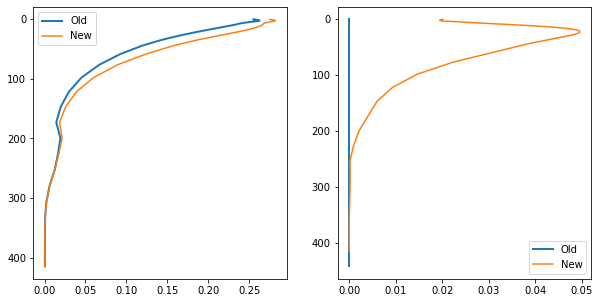

In [124]:
fig = profiles(tracer, file)

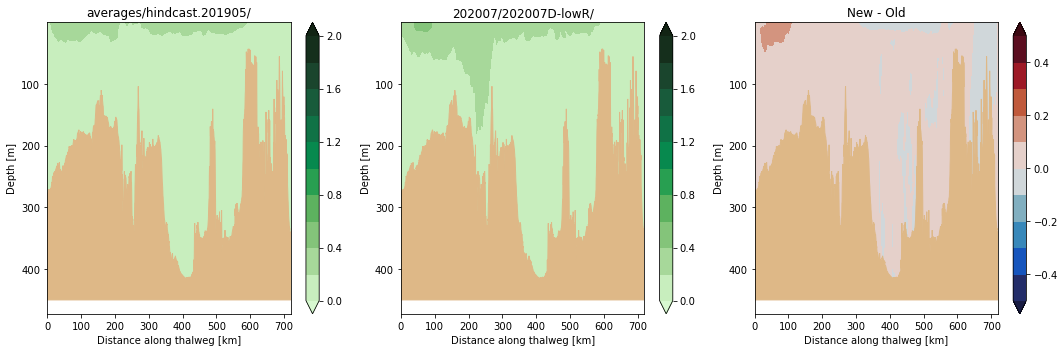

In [125]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

## February: Diatoms

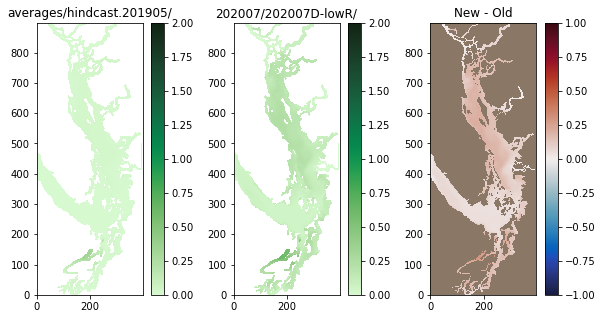

In [126]:
tracer = 'diatoms'
file = 'ptrc'
month = '02'
cmap = cm.algae
cdiff = cm.balance
vmax = 2
vmin = 0
dvmax = 1
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

0.016406771869186817 0.1230494896425687


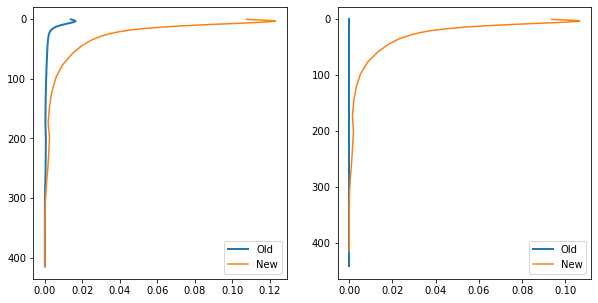

In [127]:
fig = profiles(tracer, file)

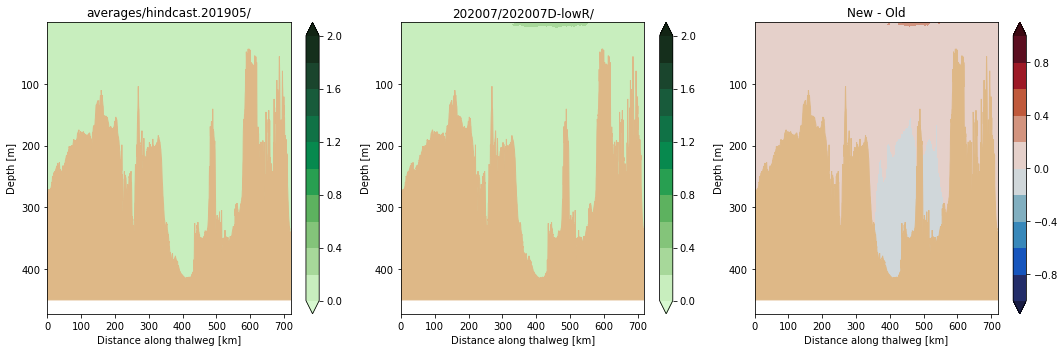

In [128]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

## March: Diatoms

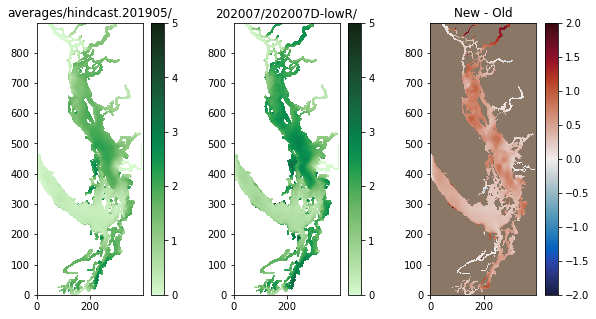

In [129]:
tracer = 'diatoms'
file = 'ptrc'
month = '03'
cmap = cm.algae
cdiff = cm.balance
vmax = 5
vmin = 0
dvmax = 2
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

0.9157428825515931 1.4192401205492267


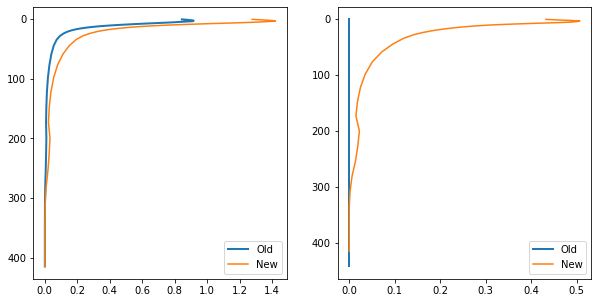

In [130]:
fig = profiles(tracer, file)

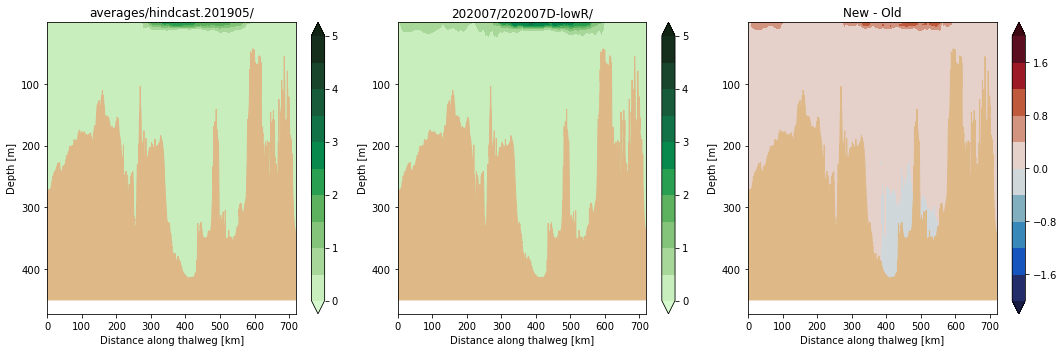

In [131]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

## March: Flagellates

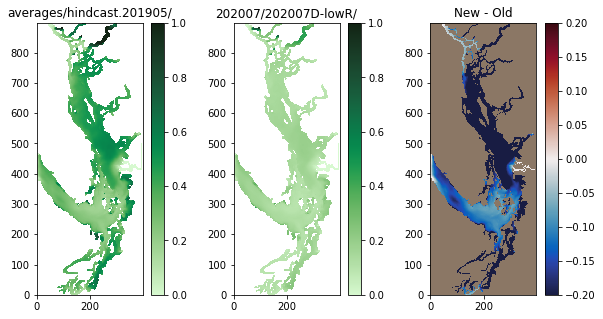

In [132]:
tracer = 'flagellates'
file = 'ptrc'
month = '03'
cmap = cm.algae
cdiff = cm.balance
vmax = 1
vmin = 0
dvmax = 0.2
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

0.3523421224787689 0.1523412079699923


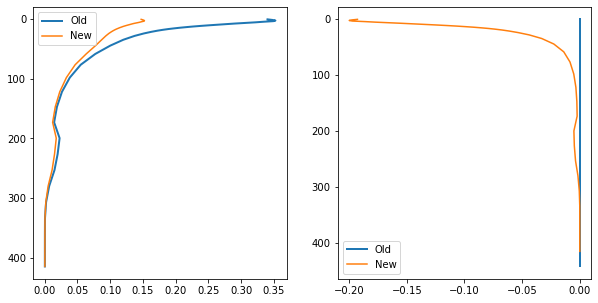

In [133]:
fig = profiles(tracer, file)

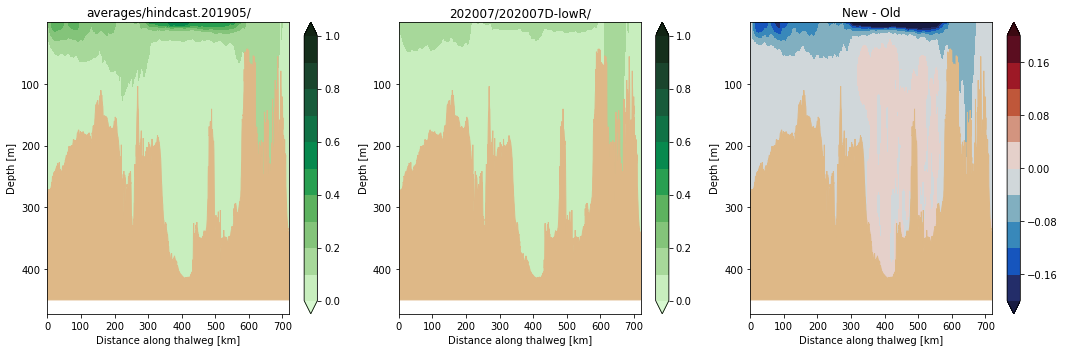

In [134]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

## April: Microzooplankton

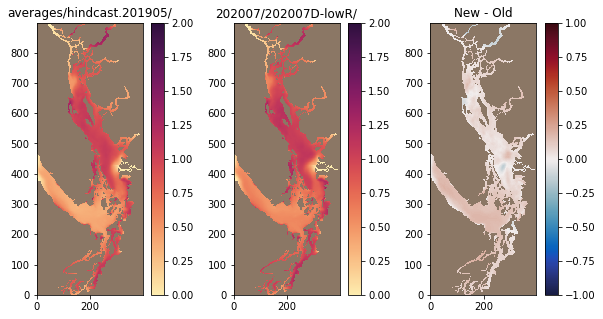

In [135]:
tracer = 'microzooplankton'
file = 'ptrc'
month = '04'
cmap = cm.matter
cmap.set_bad('#8b7765')
cb1 = "Microzooplankton (uM N)"
cdiff = cm.balance
cdiff.set_bad('#8b7765')
cb2 = 'Microzooplankton (uM N)'
vmax = 2
vmin = 0
dvmax = 1
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

0.6313905854066075 0.7231299647588082


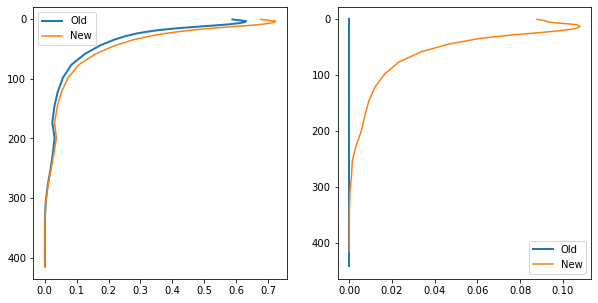

In [136]:
fig = profiles(tracer, file)

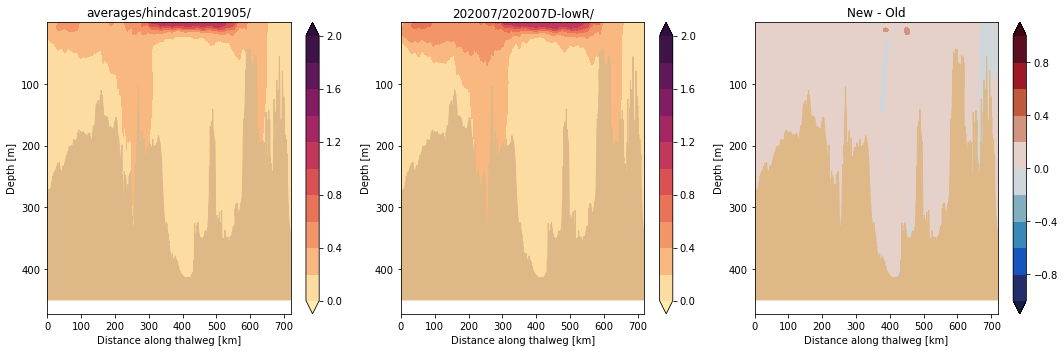

In [137]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

## May: Salinity

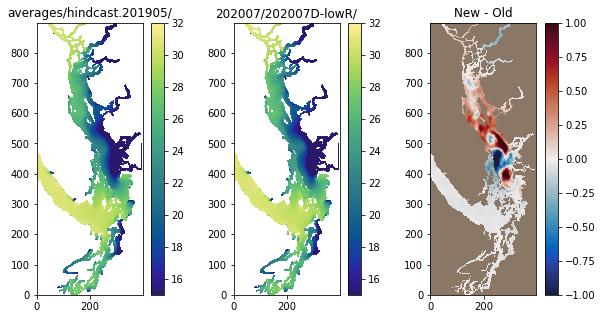

In [138]:
tracer = 'vosaline'
file = 'grid'
month = '05'
cmap = cm.haline
cdiff = cm.balance
vmax = 32
vmin = 15
dvmax = 1
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

31.80510283501261 31.802421807427773


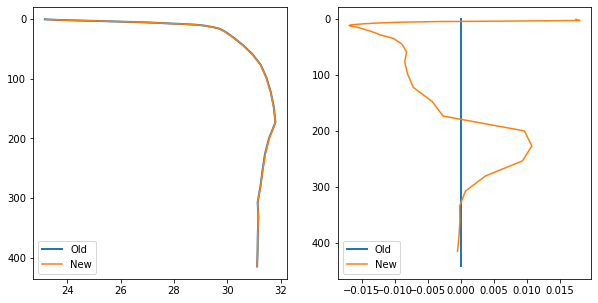

In [139]:
fig = profiles(tracer, file)

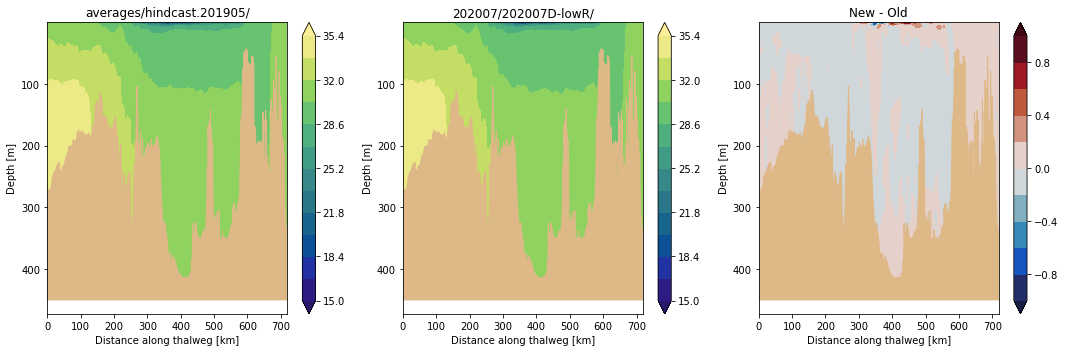

In [140]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

## May Diatoms

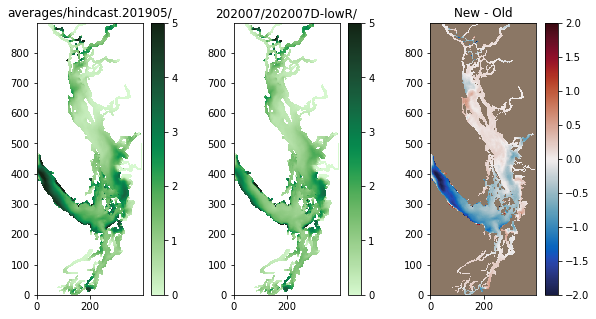

In [141]:
tracer = 'diatoms'
file = 'ptrc'
month = '05'
cmap = cm.algae
cdiff = cm.balance
vmax = 5
vmin = 0
dvmax = 2
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

1.8595141726405267 1.4823896077664918


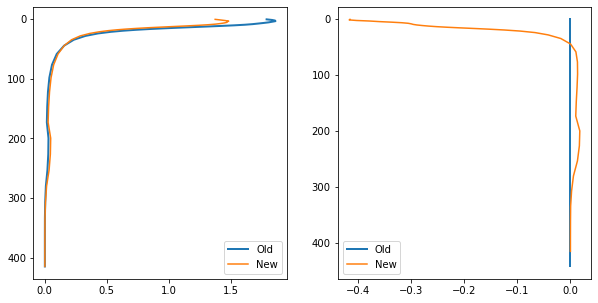

In [142]:
fig = profiles(tracer, file)

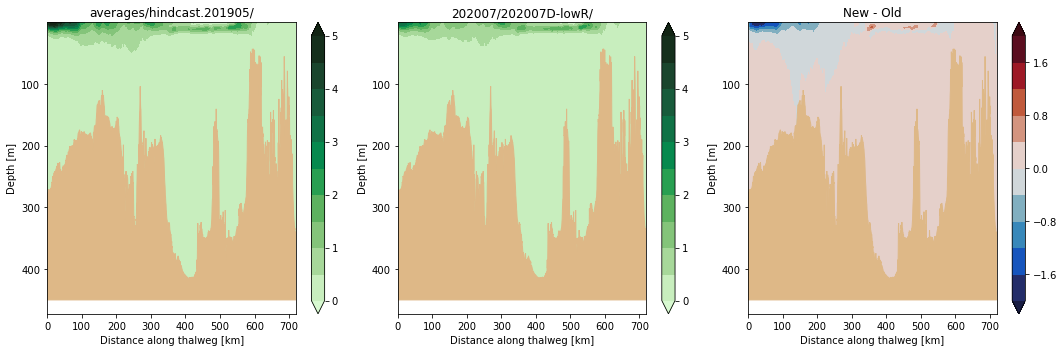

In [143]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

## May Diatoms new compared to H201812

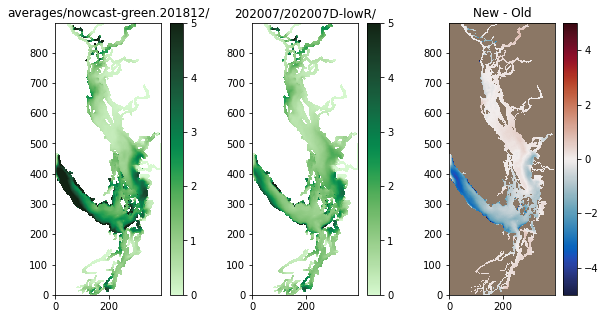

In [144]:
tracer = 'diatoms'
file = 'ptrc'
month = '05'
cmap = cm.algae
cdiff = cm.balance
vmax = 5
vmin = 0
dvmax = 5
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, 
                    olddir='averages/nowcast-green.201812/')

2.241305312051413 1.4823896077664918


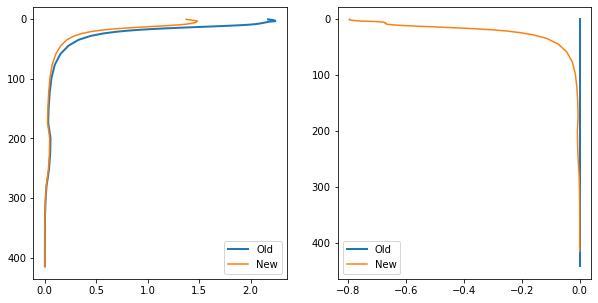

In [145]:
fig = profiles(tracer, file, olddir='averages/nowcast-green.201812/')

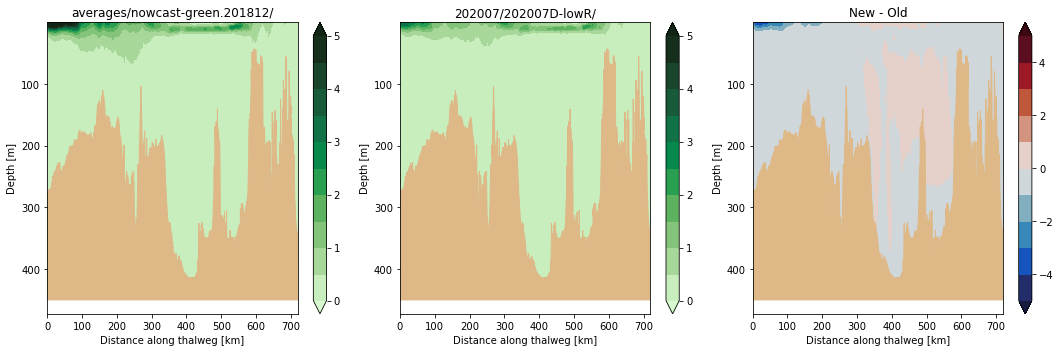

In [146]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, olddir='averages/nowcast-green.201812/')

## May Diatoms new compared to H201812

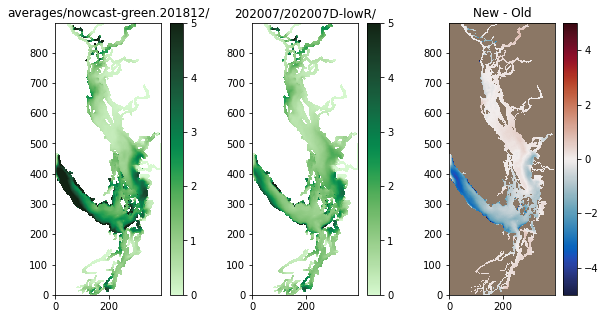

In [147]:
tracer = 'diatoms'
file = 'ptrc'
month = '05'
cmap = cm.algae
cdiff = cm.balance
vmax = 5
vmin = 0
dvmax = 5
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, 
                    olddir='averages/nowcast-green.201812/')

2.241305312051413 1.4823896077664918


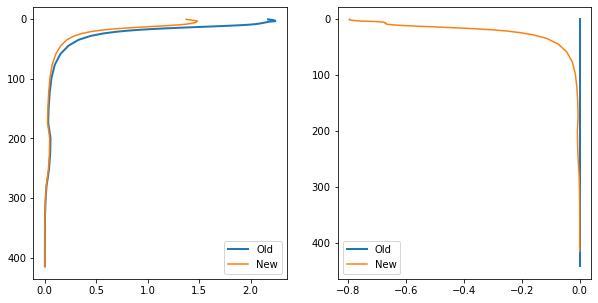

In [148]:
fig = profiles(tracer, file, olddir='averages/nowcast-green.201812/')

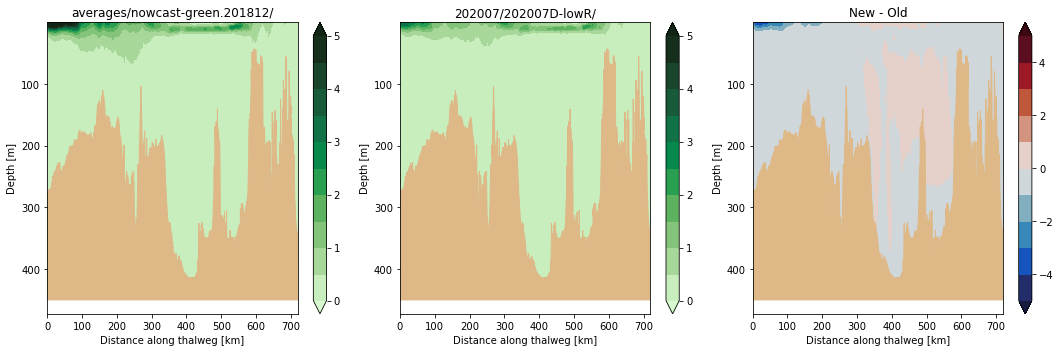

In [149]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, olddir='averages/nowcast-green.201812/')

## June: Flagellates

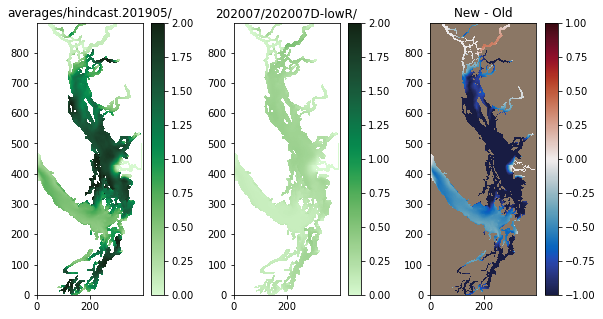

In [150]:
tracer = 'flagellates'
file = 'ptrc'
month = '06'
cmap = cm.algae
cdiff = cm.balance
vmax = 2
vmin = 0
dvmax = 1
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

1.020741227773495 0.2219568541681818


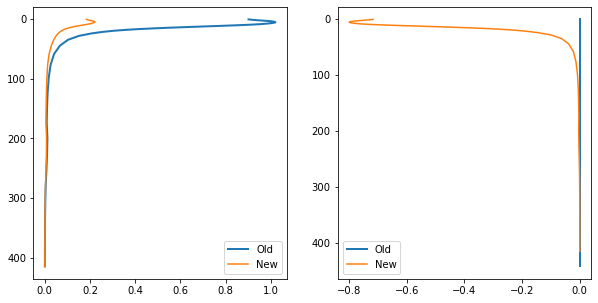

In [151]:
fig = profiles(tracer, file)

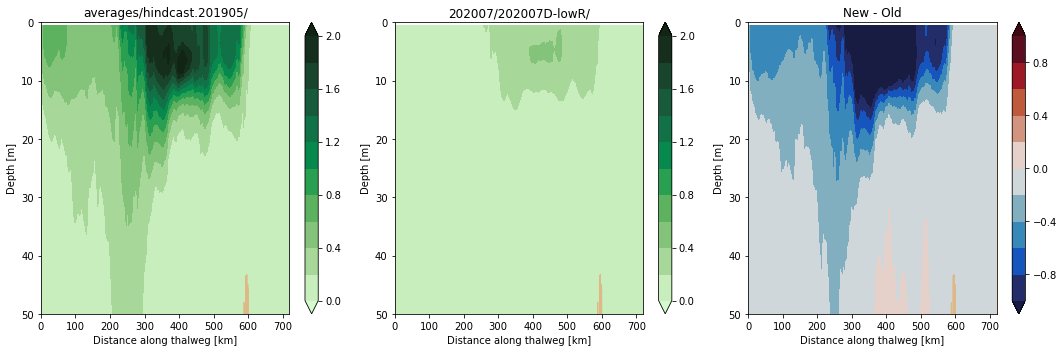

In [152]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, maxdepth=50)

## June Diatoms

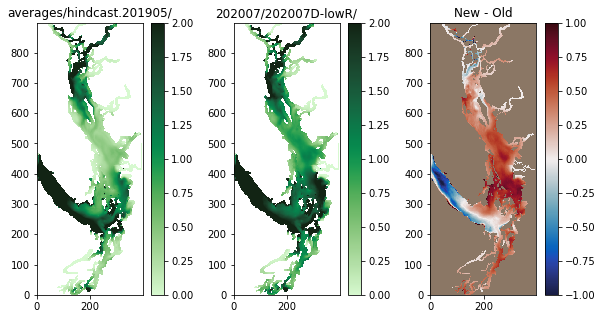

In [153]:
tracer = 'diatoms'
file = 'ptrc'
month = '06'
cmap = cm.algae
cdiff = cm.balance
vmax = 2
vmin = 0
dvmax = 1
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

1.5887074738370648 1.7376326304613137


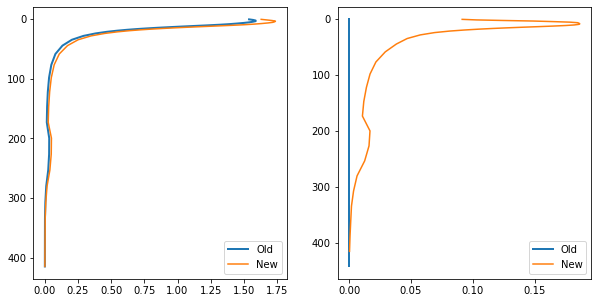

In [154]:
fig = profiles(tracer, file)

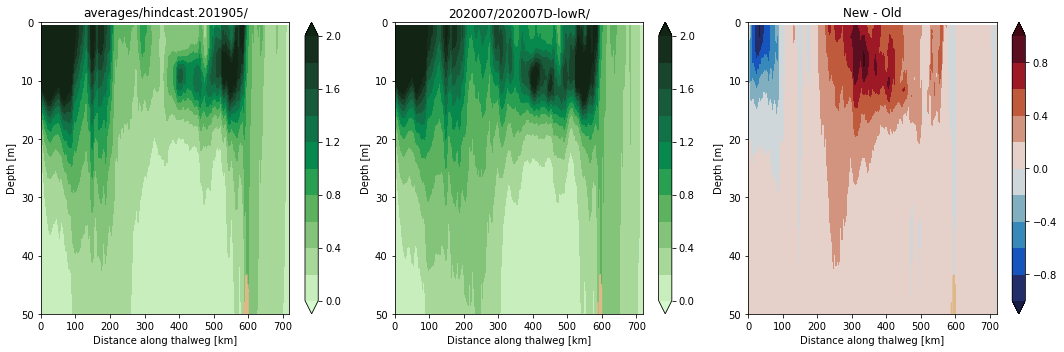

In [155]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, maxdepth=50)

## June Diatoms against 201812 Hindcast

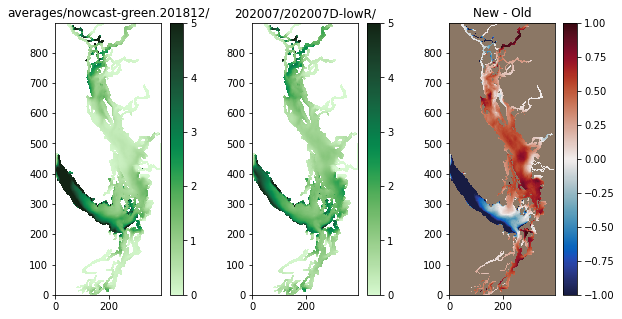

In [156]:
tracer = 'diatoms'
file = 'ptrc'
month = '06'
cmap = cm.algae
cdiff = cm.balance
vmax = 5
vmin = 0
dvmax = 1
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, 
                    olddir='averages/nowcast-green.201812/')

1.9365660122173116 1.7376326304613137


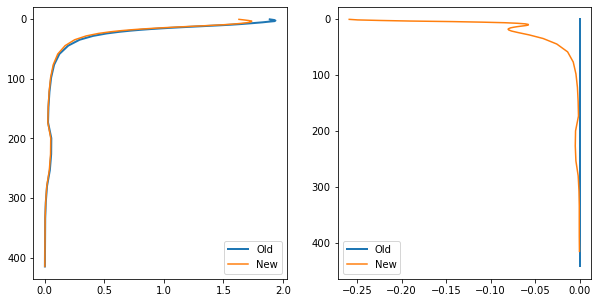

In [157]:
fig = profiles(tracer, file, olddir='averages/nowcast-green.201812/')

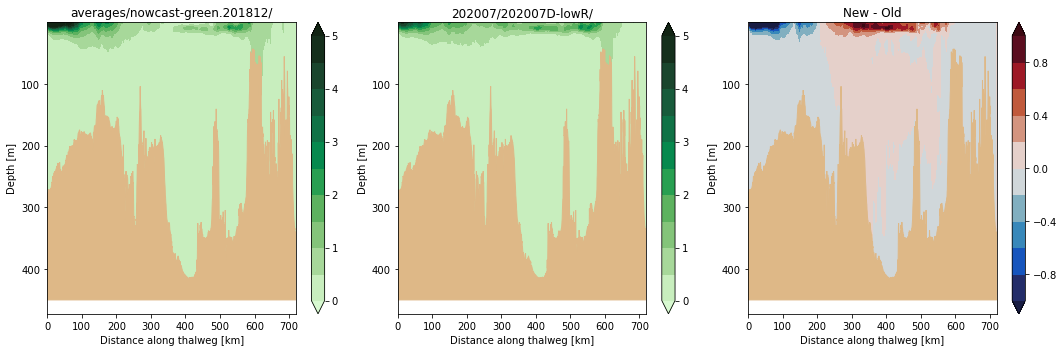

In [158]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, 
                    olddir='averages/nowcast-green.201812/')

In [159]:
newdir

'202007/202007D-lowR/'

## July : NH4

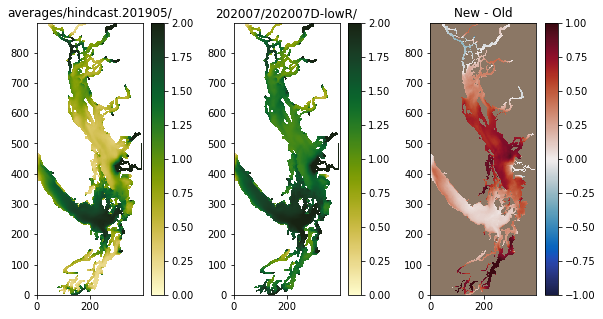

In [160]:
tracer = 'ammonium'
file = 'ptrc'
month = '07'
cmap = cm.speed
cdiff = cm.balance
vmax = 2
vmin = 0
dvmax = 1
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

2.0414554463239303 1.9893297117757134


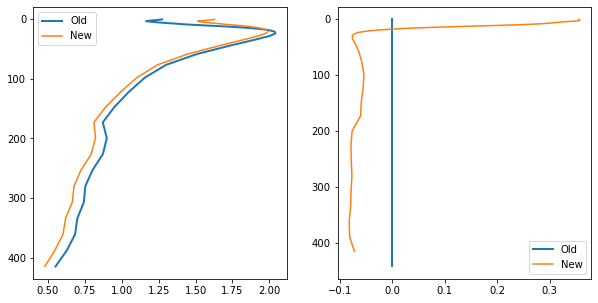

In [161]:
fig = profiles(tracer, file)

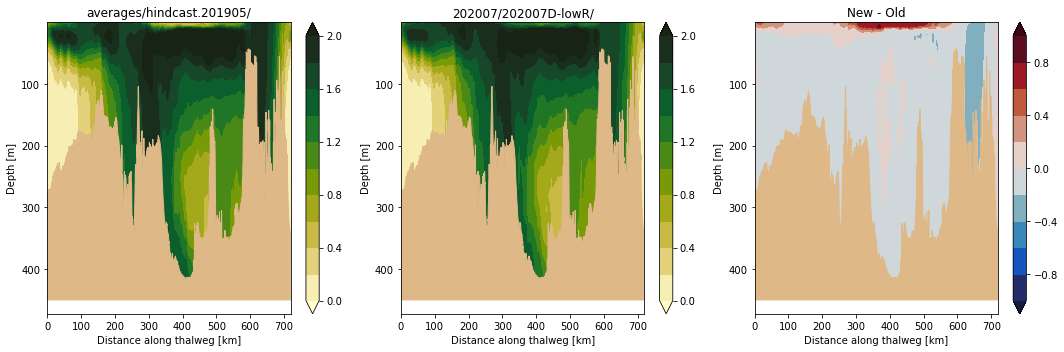

In [162]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

## July: Diatoms

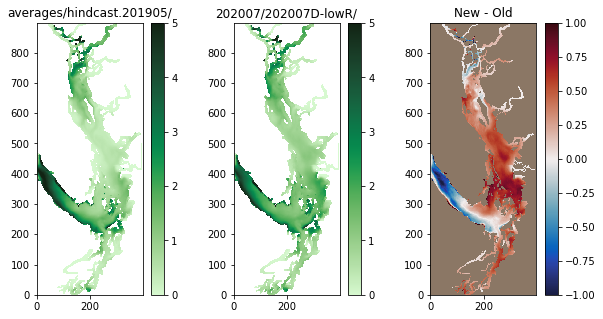

In [163]:
tracer = 'diatoms'
file = 'ptrc'
month = '06'
cmap = cm.algae
cdiff = cm.balance
vmax = 5
vmin = 0
dvmax = 1
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

1.5887074738370648 1.7376326304613137


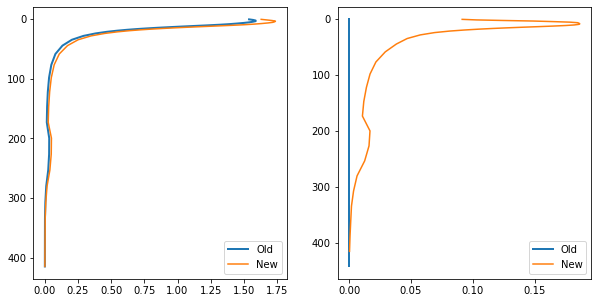

In [164]:
fig = profiles(tracer, file)

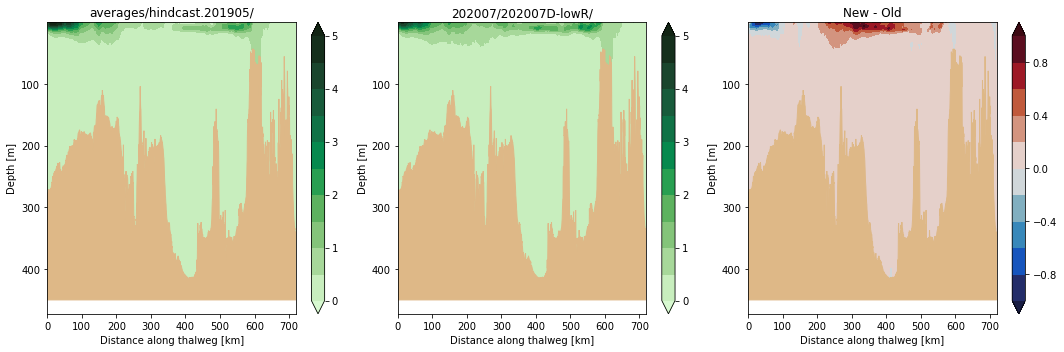

In [165]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

## August: SSH

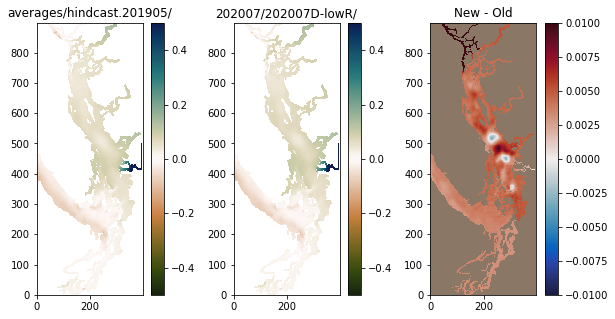

In [166]:
tracer = 'sossheig'
file = 'grid'
month = '08'
cmap = cm.tarn
cdiff = cm.balance
vmax = 0.5
vmin = -0.5
dvmax = 0.01
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, twoD=True)

## September: PON

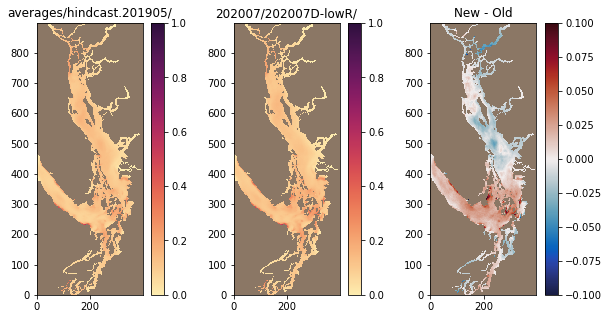

In [170]:
tracer = 'particulate_organic_nitrogen'
file = 'ptrc'
month = '09'
cmap = cm.matter
cdiff = cm.balance
vmax = 1
vmin = 0
dvmax = 0.1
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

0.2652105221881188 0.3008789202231453


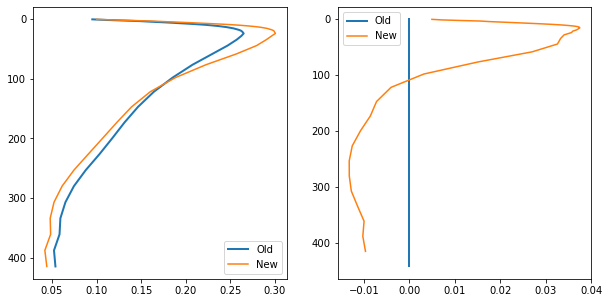

In [171]:
fig = profiles(tracer, file)

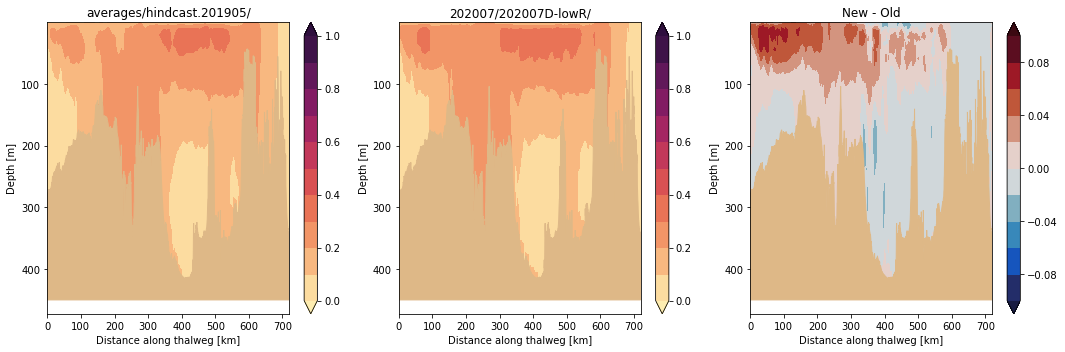

In [172]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

## October: dissolved Silicon

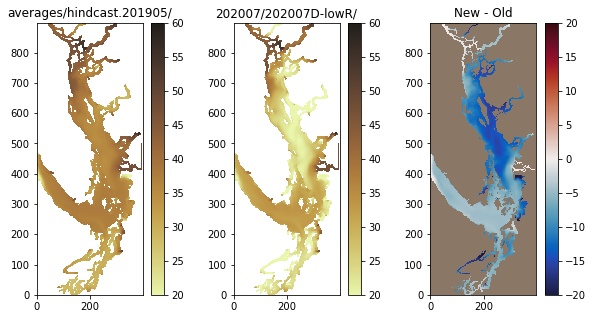

In [173]:
tracer = 'silicon'
file = 'ptrc'
month = '10'
cmap = cm.turbid
cdiff = cm.balance
vmax = 60
vmin = 20
dvmax = 20
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

66.09624630774097 73.60206093441883


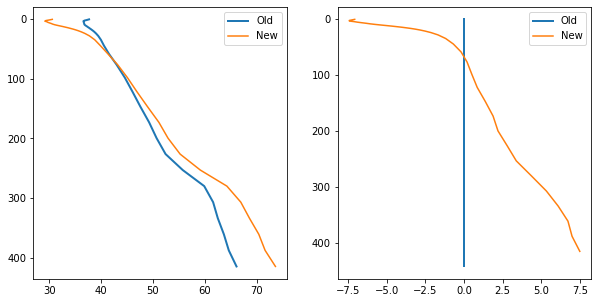

In [174]:
fig = profiles(tracer, file)

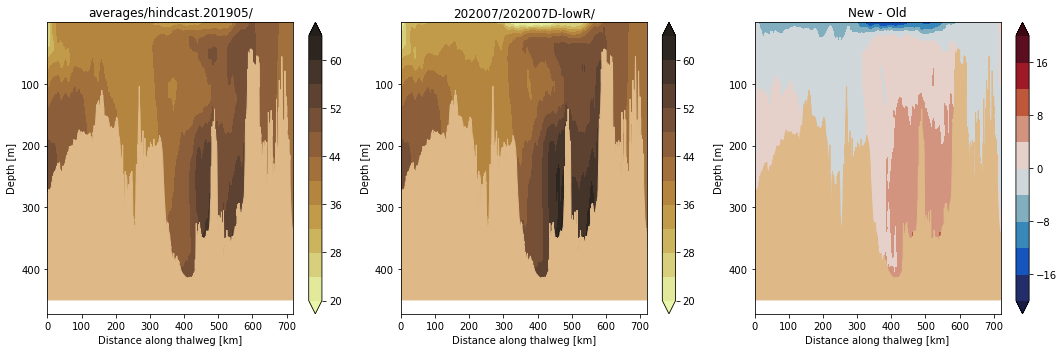

In [175]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

## November: DIC

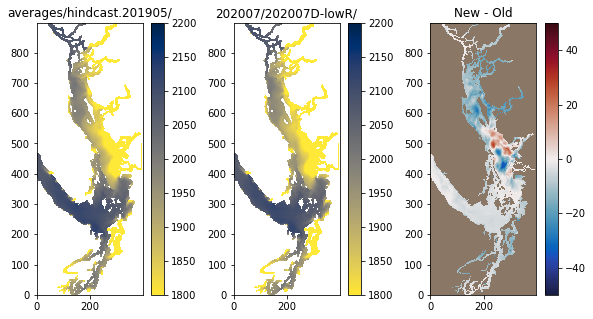

In [176]:
tracer = 'dissolved_inorganic_carbon'
file = 'carp'
month = '11'
cmap = 'cividis_r'
cdiff = cm.balance
vmax = 2200
vmin = 1800
dvmax = 50
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

2178.5702585399135 2178.2455090644153


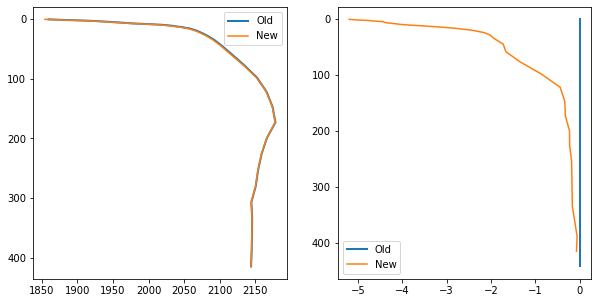

In [177]:
fig = profiles(tracer, file)

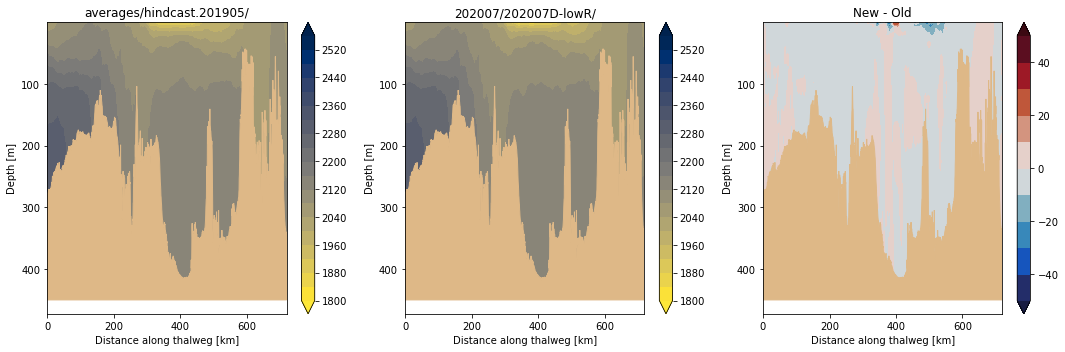

In [178]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

## November Nitrate

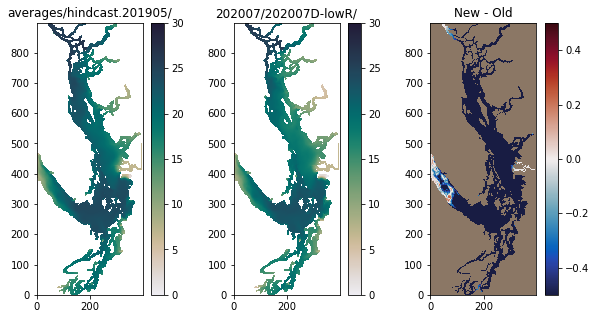

In [182]:
tracer = 'nitrate'
file = 'ptrc'
month = '11'
cmap = cm.rain
cdiff = cm.balance
vmax = 30
vmin = 0
dvmax = 0.5
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

28.18756515169584 28.180853204298685


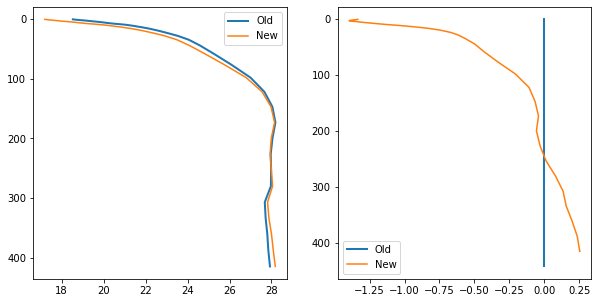

In [183]:
fig = profiles(tracer, file)

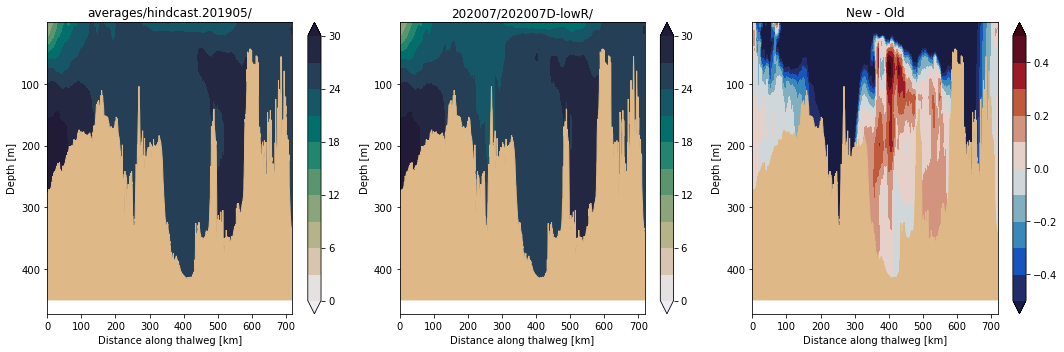

In [184]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

In [188]:
print (olddir)

averages/hindcast.201905/


## November Nitrate versus H201812

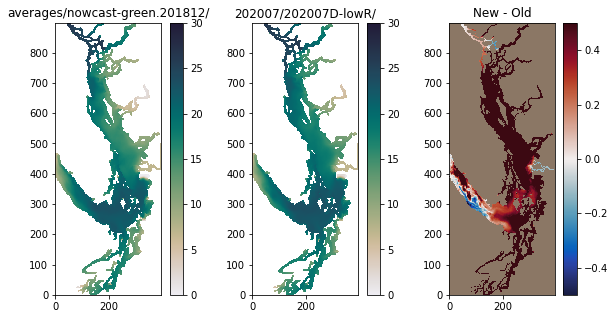

In [185]:
tracer = 'nitrate'
file = 'ptrc'
month = '11'
cmap = cm.rain
cdiff = cm.balance
vmax = 30
vmin = 0
dvmax = 0.5
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, olddir='averages/nowcast-green.201812/')

29.0721563707867 28.180853204298685


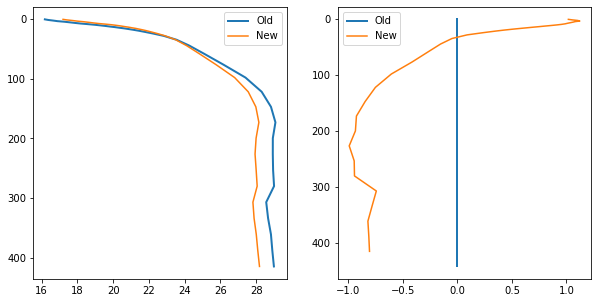

In [186]:
fig = profiles(tracer, file, olddir='averages/nowcast-green.201812/')

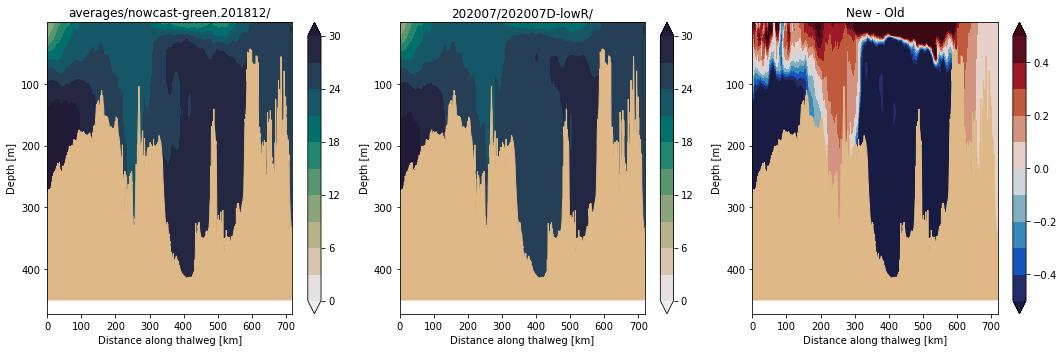

In [187]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, olddir='averages/nowcast-green.201812/')

## December Alkalinity

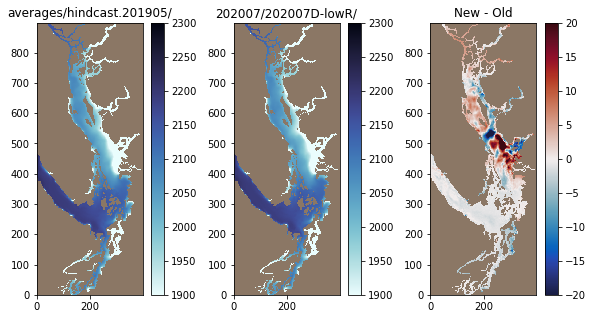

In [189]:
tracer = 'total_alkalinity'
file = 'carp'
month = '12'
cmap = cm.ice_r
cmap.set_bad('#8b7765')
cdiff = cm.balance
vmax = 2300
vmin = 1900
dvmax = 20
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

2203.9315106431036 2203.165721383449


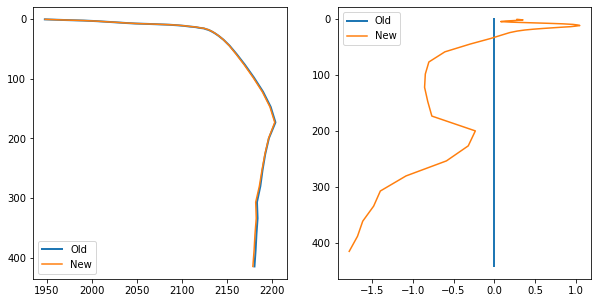

In [190]:
fig = profiles(tracer, file)

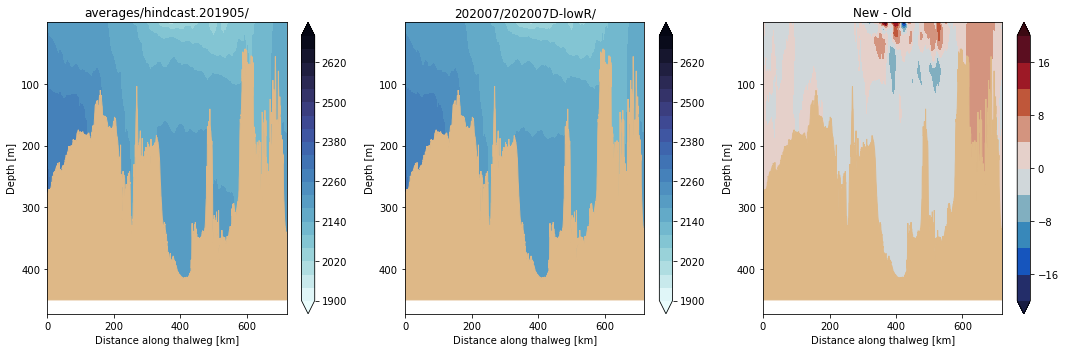

In [191]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

## December Fraser Tracer

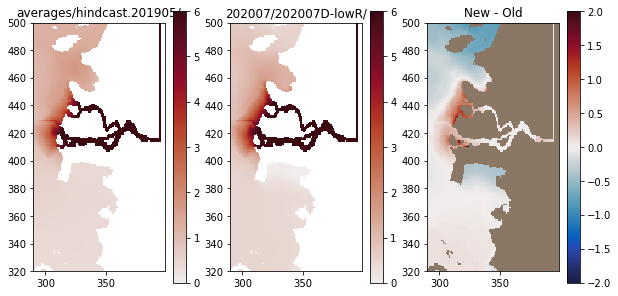

In [192]:
tracer = 'Fraser_tracer'
file = 'carp'
month = '12'
cmap = cm.amp
cdiff = cm.balance
vmax = 6
vmin = 0
dvmax = 2
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, dl=3,
                    zoom=[320, 500, 290, 398])

# Whole Year

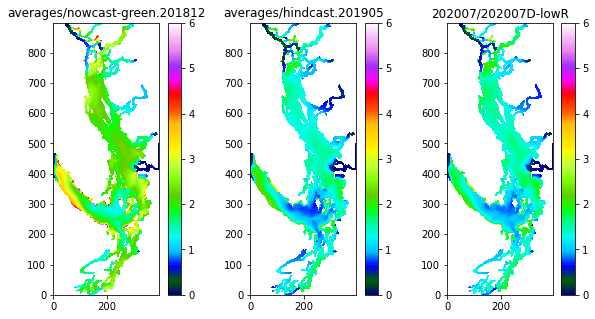

In [194]:
olddir = '202007/202007C-p2'
nextdir = '202007/202007D-again'
newdir = '202007/202007D-lowR'
nocdir = '202007/202007D-nociliates'
d201905 = 'averages/hindcast.201905'
d201812 = 'averages/nowcast-green.201812'
file = 'ptrc'
dosum = True
tracers = ['diatoms', 'flagellates', 'ciliates']
dl = 0
zoom=[0, 0, 0, 0]
cmap = 'gist_ncar'
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

dm = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{d201812}/SalishSea_1y_{year}_{year}_{file}_T.nc')

if dosum:
    dm['summed'] = 0.*dm[tracers[0]]
    for tr in tracers:
        dm['summed'] = dm['summed'] + dm[tr]
    tracer = 'summed'
else:
    tracer = tracers

mean_field = np.ma.array(dm[tracer][0, dl], mask=1-tmask[0, dl])
colours = axs[0].pcolormesh(mean_field, cmap=cmap, vmax=vmax, vmin=vmin)
axs[0].set_title(d201812)
fig.colorbar(colours, ax=axs[0])
dm.close()

dm = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{d201905}/SalishSea_1y_{year}_{year}_{file}_T.nc')

if dosum:
    dm['summed'] = 0.*dm[tracers[0]]
    for tr in tracers:
        dm['summed'] = dm['summed'] + dm[tr]
    tracer = 'summed'
else:
    tracer = tracers

mean_field = np.ma.array(dm[tracer][0, dl], mask=1-tmask[0, dl])
colours = axs[1].pcolormesh(mean_field, cmap=cmap, vmax=vmax, vmin=vmin)
axs[1].set_title(d201905)
fig.colorbar(colours, ax=axs[1])
dm.close()

ds = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{newdir}/SalishSea_1y_{year}_{year}_{file}_T.nc')
    
if dosum:
    ds['summed'] = 0.*ds[tracers[0]]
    for tr in tracers:
        ds['summed'] = ds['summed'] + ds[tr]
    
    field = np.ma.array(ds[tracer][0, dl], mask=1-tmask[0, dl])
colours = axs[2].pcolormesh(field, cmap=cmap, vmax=vmax, vmin=vmin)
axs[2].set_title(newdir)
fig.colorbar(colours, ax=axs[2])
ds.close()
    
for ax in axs:
    viz_tools.set_aspect(ax)
    if sum(zoom) > 0:
        ax.set_ylim(zoom[0], zoom[1])
        ax.set_xlim(zoom[2], zoom[3])

In [155]:
do = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{olddir}/SalishSea_1y_{year}_{year}_{file}_T.nc')
dm = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{nextdir}/SalishSea_1y_{year}_{year}_{file}_T.nc')
ds = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{newdir}/SalishSea_1y_{year}_{year}_{file}_T.nc')
dc = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{nocdir}/SalishSea_1y_{year}_{year}_{file}_T.nc')
d8 = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{d201812}/SalishSea_1y_{year}_{year}_{file}_T.nc')
d9 = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{d201905}/SalishSea_1y_{year}_{year}_{file}_T.nc')

In [157]:
imin, imax = 0, -1
jmin, jmax = 0, -1
print ('diatoms')
print (do.diatoms[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (dm.diatoms[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (ds.diatoms[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (dc.diatoms[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (d8.diatoms[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (d9.diatoms[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print ('flagellates')
print (do.flagellates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (dm.flagellates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (ds.flagellates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (dc.flagellates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (d8.flagellates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (d9.flagellates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print ('ciliates')
print (do.ciliates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (dm.ciliates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (ds.ciliates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (dc.ciliates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (d8.ciliates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (d9.ciliates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)

diatoms
3.828875
1.4032906
3.0291758
3.909907
2.984457
2.2311428
flagellates
1.3696387
1.4857436
0.67054695
2.1524587
3.5749753
1.6775682
ciliates
1.423138
1.4059978
1.2926488
0.0029192218
1.2831343
0.70409846


In [158]:
imin, imax = 350, 750
jmin, jmax = 100, 350
print ('diatoms')
print (do.diatoms[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (dm.diatoms[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (ds.diatoms[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (dc.diatoms[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (d8.diatoms[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (d9.diatoms[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print ('flagellates')
print (do.flagellates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (dm.flagellates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (ds.flagellates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (dc.flagellates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (d8.flagellates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (d9.flagellates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print ('ciliates')
print (do.ciliates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (dm.ciliates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (ds.ciliates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (dc.ciliates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (d8.ciliates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (d9.ciliates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)

diatoms
5.6858835
3.0434155
4.957744
5.7726893
4.0538135
3.2942352
flagellates
2.7545257
2.962637
1.2130283
4.362009
6.6581426
3.246883
ciliates
2.5164287
2.244411
2.343971
0.0032648724
2.2061465
1.2342718


In [159]:
print ('JdF')
imin, imax = 200, 500
jmin, jmax = 0, 200
print ('diatoms')
print (do.diatoms[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (dm.diatoms[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (ds.diatoms[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (dc.diatoms[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (d8.diatoms[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (d9.diatoms[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print ('flagellates')
print (do.flagellates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (dm.flagellates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (ds.flagellates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (dc.flagellates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (d8.flagellates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (d9.flagellates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print ('ciliates')
print (do.ciliates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (dm.ciliates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (ds.ciliates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (dc.ciliates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (d8.ciliates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (d9.ciliates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)

JdF
diatoms
5.037778
0.6009423
3.2255769
5.3142023
4.5759244
3.0645819
flagellates
0.78225476
1.0290838
0.5251834
1.1030508
2.519186
1.0694559
ciliates
1.1150256
1.3939369
0.9518109
0.00040108478
1.0843229
0.5705489


In [162]:
3.6/7.9

0.45569620253164556

In [163]:
1.7/4.6

0.3695652173913044

In [164]:
8.2/12.9

0.6356589147286821

In [165]:
4.8/7.7

0.6233766233766234

In [147]:
3.8/6.6

0.5757575757575758

In [148]:
1.4/4.3

0.3255813953488372

In [149]:
3.9/6

0.65

In [150]:
.7/6

0.11666666666666665

In [151]:
1.5/4.3

0.3488372093023256

In [153]:
1.4/6.6

0.21212121212121213